In [11]:
import pandas as pd 
from rdkit import Chem
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re 
from typing import List
import numpy as np 
from math import exp
import matplotlib.pyplot as plt

In [16]:
import torch
def get_num_parameters(model):
    """Return the number of trainable parameters in the model."""
    # check if the model is trainable 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_num_parameters_per_layer(model):
    """Return the number of trainable parameters in the model per layer."""
    layers = {}
    for name, p in model.named_parameters():
        if p.requires_grad:
            layers[name] = p.numel()
    return layers

# which one is available (CPU, GPU, or Apple Silicon MPS) 
def set_device():
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            device = 'mps'
    elif torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

device = set_device()

In [17]:
# load dataset
!wget 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/zinc15_250K_2D.tar.gz'
!tar -xzf zinc15_250K_2D.tar.gz

--2024-08-05 11:27:00--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/zinc15_250K_2D.tar.gz
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.120.105, 52.219.192.50, 52.219.120.201, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.120.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6941580 (6.6M) [application/x-gzip]
Saving to: ‘zinc15_250K_2D.tar.gz’

zinc15_250K_2D.tar. 100%[===================>]   6.62M  4.91MB/s    in 1.3s    

2024-08-05 11:27:03 (4.91 MB/s) - ‘zinc15_250K_2D.tar.gz’ saved [6941580/6941580]



In [18]:
df = pd.read_csv('zinc15_250K_2D.csv')

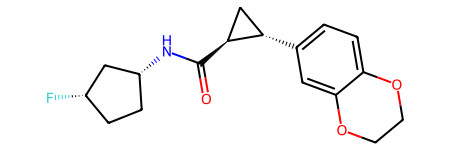

In [22]:
Chem.MolFromSmiles(df['smiles'][3])


In [23]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [24]:
print(len(df))


250000


In [31]:
print (np.shape(df))
train, valid, test = torch.utils.data.random_split(df['smiles'], [200000, 25000, 25000])


(250000, 7)


In [26]:
def tokenize(smiles: str) -> List[str]:
    """
    Tokenize a SMILES

    Args:
        smiles (str): SMILES string
    
    Returns:
        List[str]: List of tokens
    """
    SMI_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
    
    return re.findall(SMI_REGEX_PATTERN, smiles)

In [27]:
tokenize('CCO')

['C', 'C', 'O']

In [28]:
tokenize('c1ccccc1')

['c', '1', 'c', 'c', 'c', 'c', 'c', '1']

In [29]:
class Tokenizer:
    def __init__(self, tokens: List[str], eos: str = '[EOS]', bos: str = '[BOS]', pad: str = '[PAD]', unk: str = '[UNK]'):
        self.tokens = [pad, bos, eos, unk] + tokens
        self._token_to_index = {token: index for index, token in enumerate(self.tokens)}
        self.index_to_token = {index: token for index, token in enumerate(self.tokens)}

    def token_to_index(self, token: str) -> int:
        try:
            return self._token_to_index[token]
        except KeyError:
            return self._token_to_index['[UNK]']
        
    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, item):
        return self.token_to_index[item]
    
    def __contains__(self, item):
        return item in self.tokens

    def encode(self, smiles: str, add_sos: bool=False, add_eos: bool=False) -> List[int]:
        """
        Encode a SMILES into a list of indices

        Args:
            smiles (str): SMILES string
            add_sos (bool): Add start of sentence token
            add_eos (bool): Add end of sentence token

        Returns:
            List[int]: List of indices
        """
        tokens = []
        if add_sos:
            tokens.append(self.token_to_index('[BOS]'))
        tokens += [self.token_to_index(token) for token in tokenize(smiles)]
        if add_eos:
            tokens.append(self.token_to_index('[EOS]'))
        return tokens
    
    def decode(self, indices: List[int], strip_special_tokens: bool = True) -> str: 
        """
        Decode a list of indices into a SMILES

        Args:
            indices (List[int]): List of indices
        
        Returns:
            str: SMILES string
        """
        decoded = ''.join([self.index_to_token[index] for index in indices])
        if strip_special_tokens:
            return decoded.replace('[PAD]', '').replace('[BOS]', '').replace('[EOS]', '')
        return decoded

In [32]:
tokens = set()
lengths = []
for smiles in train.dataset.values:
    tokens_ = tokenize(smiles)
    tokens.update(tokens_)
    lengths.append(len(tokens_))

(array([3.0000e+00, 4.0000e+00, 7.0000e+00, 0.0000e+00, 2.3000e+01,
        5.6000e+01, 0.0000e+00, 7.8000e+01, 2.0100e+02, 0.0000e+00,
        3.8900e+02, 8.0200e+02, 1.4320e+03, 0.0000e+00, 2.5760e+03,
        3.9450e+03, 0.0000e+00, 5.8570e+03, 8.0820e+03, 0.0000e+00,
        1.0313e+04, 1.2675e+04, 1.4914e+04, 0.0000e+00, 1.7137e+04,
        1.8718e+04, 0.0000e+00, 2.0510e+04, 2.0796e+04, 0.0000e+00,
        2.1073e+04, 2.0330e+04, 1.8396e+04, 0.0000e+00, 1.6193e+04,
        1.2172e+04, 0.0000e+00, 9.8210e+03, 5.8470e+03, 0.0000e+00,
        3.9460e+03, 2.1220e+03, 9.6800e+02, 0.0000e+00, 4.1200e+02,
        1.4500e+02, 0.0000e+00, 4.6000e+01, 1.0000e+01, 1.0000e+00]),
 array([17. , 17.7, 18.4, 19.1, 19.8, 20.5, 21.2, 21.9, 22.6, 23.3, 24. ,
        24.7, 25.4, 26.1, 26.8, 27.5, 28.2, 28.9, 29.6, 30.3, 31. , 31.7,
        32.4, 33.1, 33.8, 34.5, 35.2, 35.9, 36.6, 37.3, 38. , 38.7, 39.4,
        40.1, 40.8, 41.5, 42.2, 42.9, 43.6, 44.3, 45. , 45.7, 46.4, 47.1,
        47.8, 48.5, 49

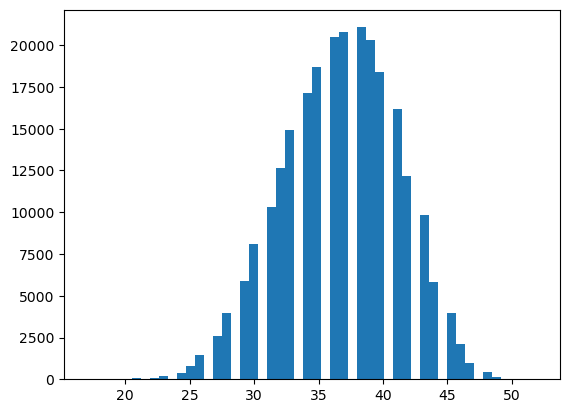

In [33]:
plt.hist(lengths, bins=50)

In [35]:
tokenizer = Tokenizer(list(tokens))


In [36]:
tokenizer.encode('CCO')

[27, 27, 19]

In [37]:
tokenizer.decode([27, 27, 19])

'CCO'

In [38]:
B, T, C = 2, 3, 4 # batch size, sequence length, embedding size
x = torch.rand(B, T, C)
pos = torch.arange(T).unsqueeze(0).repeat(B, 1)

In [ ]:
# till langauge modeling data set 